In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-05_17-23_20180601_20191231_fixed_base_old_atr.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.004009163802978236

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
YM       0.25
NQ       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES    23027.6
GC    12892.4
NQ    29642.4
YM    29159.8
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

94722.20000000001

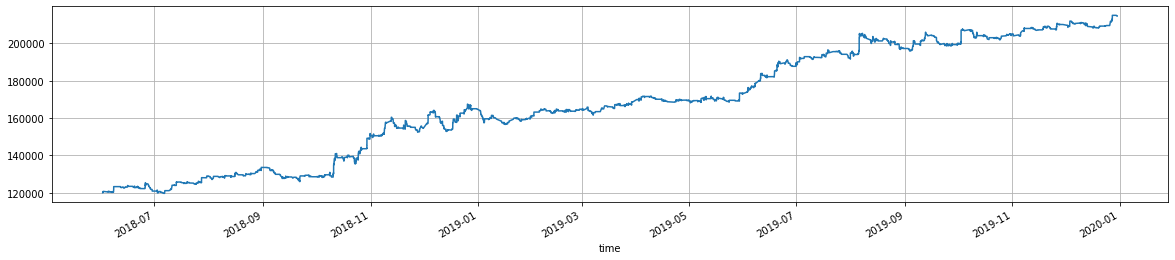

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     344
 GC     780
 NQ    1906
 YM     462
 Name: action, dtype: int64,
 3492)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.834951
 GC    1.893204
 NQ    4.626214
 YM    1.121359
 Name: action, dtype: float64,
 8.475728155339805)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     722.4
GC    1887.6
NQ    4002.6
YM     970.2
Name: commission, dtype: float64

In [16]:
df.commission.sum()

7582.800000000001

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.40,33.06,489.52,-271.25,1.80,33.06,390.0
NQ,0.40,31.10,459.11,-253.98,1.81,31.26,953.0
YM,0.45,126.23,756.67,-381.07,1.99,130.91,231.0
ES,0.45,133.88,987.68,-558.15,1.77,137.47,172.0
total,0.41,54.25,565.24,-301.80,1.87,53.69,1746.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.036755,0.172212,0.491003,0.687526
GC,-0.036755,1.000000,0.065342,0.046826,0.354130
NQ,0.172212,0.065342,1.000000,0.247537,0.664873
YM,0.491003,0.046826,0.247537,1.000000,0.722240
total,0.687526,0.354130,0.664873,0.722240,1.000000


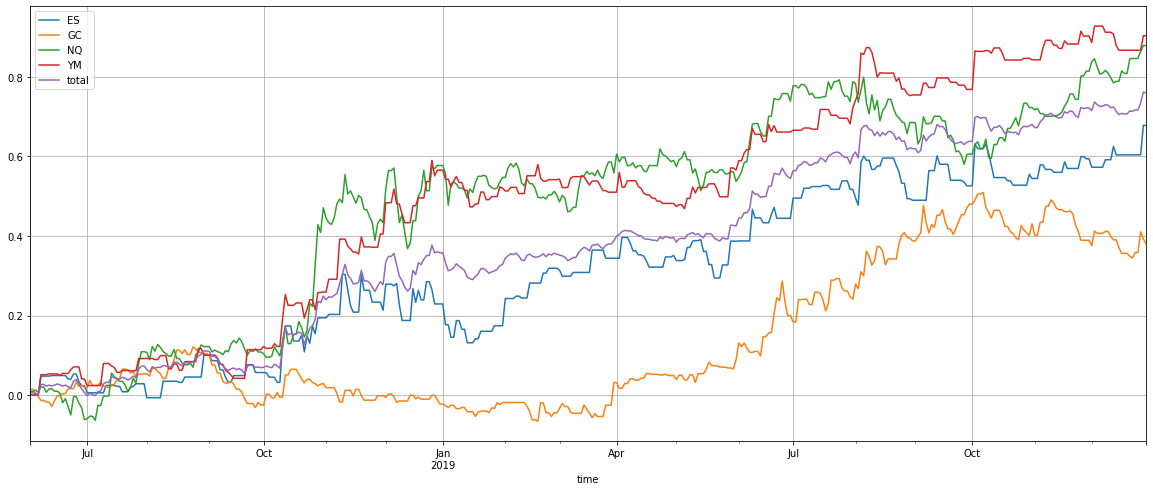

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

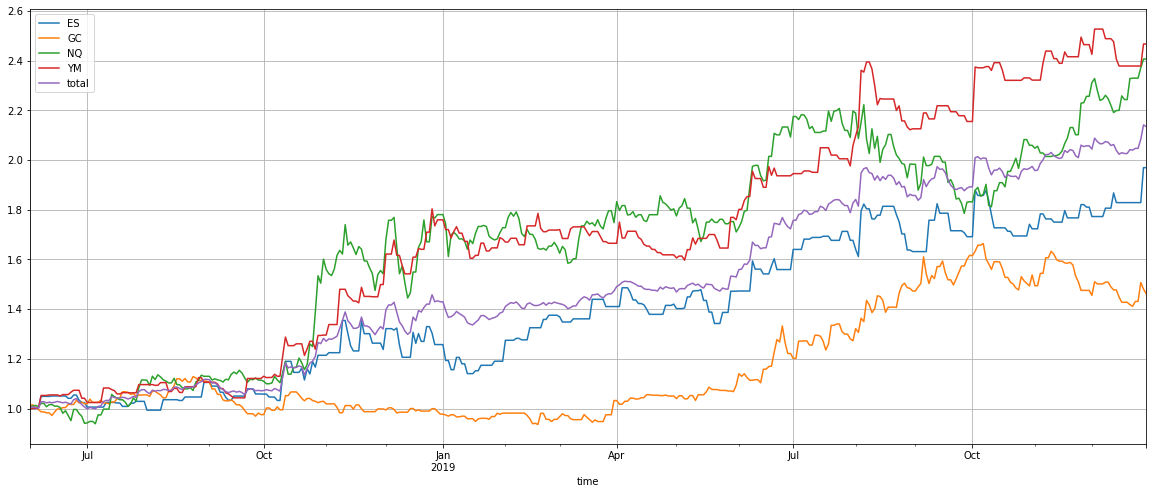

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.513627,0.261824,0.711098,0.737150,0.590195
Cumulative returns,0.969322,0.462598,1.406500,1.466693,1.134791
Annual volatility,0.336075,0.247731,0.367845,0.293245,0.194247
Sharpe ratio,1.396993,1.061050,1.642972,2.027384,2.485532
Calmar ratio,3.255707,1.534120,3.613277,6.436677,6.525715
Stability,0.942021,0.650672,0.836499,0.935314,0.967277
Max drawdown,-0.157762,-0.170667,-0.196801,-0.114523,-0.090441
Omega ratio,1.469123,1.245544,1.369469,1.710695,1.642563
Sortino ratio,2.868537,1.942059,2.818995,4.548735,5.182519
Skew,2.167302,1.299760,0.746791,2.285307,1.788443


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,2.40,1.97,-5.94,4.16,0.67
2018-07-31,0.49,3.48,18.56,5.26,6.89
2018-08-31,7.41,5.22,1.32,0.87,3.85
2018-09-30,-4.22,-12.14,-1.36,1.36,-4.12
2018-10-31,14.71,5.52,43.67,15.58,19.67
2018-11-30,1.92,-2.99,-3.68,15.69,2.96
2018-12-31,1.60,-2.09,15.44,17.38,8.29
2019-01-31,-5.32,0.40,-2.96,-4.41,-2.87
2019-02-28,15.53,-2.53,-4.40,2.16,2.60


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        97.0
GC        46.0
NQ       141.0
YM       147.0
total    113.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-08-05 21:22:30,ES,BUY,2843.00,3408.3
2019-10-02 21:00:00,ES,BUY,2893.75,3320.8
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
2018-11-08 20:40:00,YM,SELL,26092.00,3180.8
2018-11-09 09:08:00,ES,SELL,2796.25,3170.8
...,...,...,...,...
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2018-12-18 21:49:00,ES,BUY,2559.75,-1204.2
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.043839,0.030793,0.106360,0.073651
2019-10-02,0.110693,0.011183,0.025633,0.101693,0.062301
2018-12-03,0.067777,-0.003989,0.088913,0.081860,0.058640
2018-10-10,0.103193,0.000000,0.035380,0.073053,0.052907
2018-10-11,0.044580,0.057183,0.040607,0.061913,0.051071
...,...,...,...,...,...
2018-11-21,-0.038473,-0.011828,-0.028780,-0.024640,-0.025930
2018-11-13,-0.038890,0.000011,-0.047367,-0.017613,-0.025965
2018-10-22,-0.041530,-0.009161,-0.023087,-0.037113,-0.027723
